In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

class GridWorld:
    def __init__(self, n_rows, n_cols, bonus_states):
        """
            :param bonus_states: sequence of triples (begin, end, reward)
        """
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.bonus_states = bonus_states
        self.rewards = np.zeros(n_rows*n_cols)
        self.probs = np.zeros((n_rows*n_cols, n_rows*n_cols))
        self.values = np.zeros(n_rows*n_cols)
        self.set_rewards()
        self.set_probs()
    
    def set_rewards(self):
        for i in range(self.n_cols):
            self.rewards[i] -= 0.25
            self.rewards[self.n_rows*self.n_cols - 1 - i] -= 0.25
        
        for i in range(self.n_rows):
            self.rewards[i*self.n_cols] -= 0.25
            self.rewards[i*self.n_cols + self.n_cols-1] -= 0.25
        
        for begin, end, reward in self.bonus_states:
            self.rewards[begin] = reward
            
    def set_probs(self):
        for i in range(self.n_rows*self.n_cols):
            up = i - self.n_cols
            right = i + 1
            down = i + self.n_cols
            left = i - 1
    
            # near the boundaries something changes
            if i % self.n_cols == 0:
                left = i
            if i % self.n_cols == self.n_cols - 1:
                right = i
            if i // self.n_cols == 0:
                up = i
            if i // self.n_cols == self.n_rows - 1:
                down = i
    
            self.probs[i, up] += 0.25
            self.probs[i, right] += 0.25
            self.probs[i, down] += 0.25
            self.probs[i, left] += 0.25
        
        for begin, end, _ in self.bonus_states:
            self.probs[begin, :] = 0
            self.probs[begin, end] = 1
            
    def __repr__(self):
        return str(self.rewards.reshape((self.n_rows, -1)))
    
    def bellman_solution(self, gamma=0.9):
        v = np.linalg.inv(np.eye(self.n_rows*self.n_cols) - gamma * self.probs).dot(self.rewards)
        return v.reshape(self.n_cols, -1)
    
    def update_state_values(self, gamma=0.9):
        new_values = np.zeros_like(self.values)
        for i in range(self.n_rows*self.n_cols):
            up = i - self.n_cols
            right = i + 1
            down = i + self.n_cols
            left = i - 1
            up_reward, left_reward, down_reward, right_reward = 0, 0, 0, 0
            # near the boundaries something changes
            if i % self.n_cols == 0:
                left = i
                left_reward = -1
            if i % self.n_cols == self.n_cols - 1:
                right = i
                right_reward = -1
            if i // self.n_cols == 0:
                up = i
                up_reward = -1
            if i // self.n_cols == self.n_rows - 1:
                down = i
                down_reward= -1
            up_value = up_reward + gamma*self.values[up]
            down_value = down_reward + gamma*self.values[down]
            left_value = left_reward + gamma*self.values[left]
            right_value = right_reward + gamma*self.values[right]
            new_values[i] = max(up_value, down_value, left_value, right_value)
            
        for begin, end, reward in self.bonus_states:
            new_values[begin] = reward + gamma*self.values[end]
        diff = np.linalg.norm(new_values - self.values)
        self.values = new_values
        return diff

# Markov Decision Process (MDP)

## MDP-1

$(\mathcal S, \mathcal A, p, \gamma)$:

* $\mathcal S$ is a set of all possible states
* $\mathcal A$ — set of actions (can depend on $s \in\mathcal S$)
* $p(r, s' \vert s, a)$ — joint probability distribution of reward $r$ and next state $s'$ given state $s$ and action $a$ 
* $\gamma \in [0,1]$ — discount factor

## MDP-2

$(\mathcal S, \mathcal A, p, \mathcal R, \gamma)$:

* $\mathcal S$ is a set of all possible states
* $\mathcal A$ — set of actions
* $p(s' \vert s, a)$ is the probability of transitioning to $s'$, given a state $s$ and action $a$
* $\mathcal R \colon \mathcal S \times \mathcal A \to \mathbb R$ — expected reward: $\mathcal R(s, a) = \mathbb E[R \vert s, a]$
* $\gamma \in [0,1]$ — discount factor

````{admonition} Question
:class: important

How to obtain MDP-2 from MDP-1?

```{admonition} Answer
:class: dropdown, tip

$$
\mathcal R(s, a) = \mathbb E[R \vert s, a]
 = \sum\limits_{r, s'} rp(r, s' | s, a), \quad
p(s' | s, a) = \sum\limits_{r} p(r, s' | s, a)
$$

```
````



## Value function

Value (**expected return**) of following policy $\pi$ from state $s$:

$$
    v_\pi(s) = \mathbb E_\pi[G_t \vert S_t = s]
$$

**Bellman expectation equality** for $v_\pi(s)$

MDP-1:

$$
     v_\pi(s) = \sum\limits_{a\in\mathcal A} \pi(a\vert s) \sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_{\pi}(s'))
$$

MDP-2:

$$
     v_\pi(s) = \sum\limits_{a\in\mathcal A} \pi(a\vert s) \Big(\mathcal R(s, a) + \gamma \sum\limits_{s'}p(s'\vert s, a) v_{\pi}(s')\Big)
$$

Note that we need to fix some policy $\pi$ in this equation.

````{admonition} Exericse
:class: important
Check that Bellman expectation equality holds for the center state of the gridworld.

```{figure} ./gridworld.png
:align: center
```
````

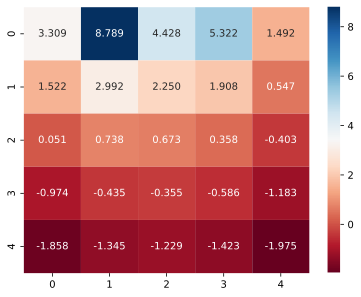

In [2]:
grid = GridWorld(5, 5, [(1, 21, 10), (3, 13, 5)])
values = grid.bellman_solution()
sns.heatmap(values, cmap='RdBu', annot=True, fmt=".3f");

## Action-value function

Value (**expected return**) of following policy $\pi$ after committing action $a$ state $s$:

$$
    q_\pi(s, a) = \mathbb E_\pi[G_t \vert S_t = s, A_t = a]
$$

````{admonition} Question
:class: important
How to write $v_\pi(s)$ in terms of $q_\pi(s, a)$?

```{admonition} Answer
:class: tip, dropdown

$$
v_\pi(s) = \sum\limits_a \pi(a\vert s) q_\pi(s, a)
$$

```
````

**Bellman expectation equality** for $q_\pi(s, a)$

MDP-1:

$$
    q_\pi(s,a) = \sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_{\pi}(s'))
$$

Since $v_\pi(s) = \sum\limits_{a} \pi(a\vert s) q_\pi(s, a)$, we obtain

$$
    q_\pi(s,a) = \sum\limits_{r, s'}p(r, s'\vert s, a)\Big(r + \gamma \sum\limits_{a'}\pi(a'\vert s') q_\pi(s', a')\Big)
$$

MDP-2:

$$
    q_\pi(s,a) =  \mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a)\sum\limits_{a'}\pi(a'\vert s') q_\pi(s', a')
$$

Once again the equation stands for some fixed policy $\pi$

## Optimal policy

Optimal policy $\pi_*$ is the one with the largest $v_\pi(s)$:

$$
    v_*(s) = \max\limits_\pi v_\pi(s), \quad v_*(s) = v_{\pi_*}(s)
$$
$$
    q_*(s, a) = \max\limits_\pi q_\pi(s, a), \quad q_*(s, a) = q_{\pi_*}(s, a)
$$

Note that both $v_*(s)$ and $q_*(s, a)$ do not depend on $\pi$ anymore

If we now optimal action-value function $q_*(s, a)$, then the optimal deterministic policy can be found as

$$
    \pi_*(a\vert s) = \begin{cases}
    1, & a = \arg\max\limits_a q_*(s, a), \\
    0, & \text{otherwise}.
    \end{cases}
$$

**Bellman optimality equality** for $v_*(s)$

MDP-1:

$$
v_*(s) = \max\limits_a q_*(s, a) = \max\limits_a\sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_*(s'))
$$

MDP-2:

$$
v_*(s) = \max\limits_a \Big\{\mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a)v_*(s')\Big\}
$$

**Bellman optimality equality** for $q_*(s, a)$

MDP-1:

$$
q_*(s, a) = \sum\limits_{r, s'}p(r, s'\vert s, a)\big(r + \gamma  \max\limits_{a'} q_*(s', a')\big)
$$

MDP-2:

$$
q_*(s, a) = \mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a) \max\limits_{a'} q_*(s', a')
$$

<img src="./gridworld_solved.png" style="height: 400px">

```{admonition} Exercise
:class: important
Compute $v_*$ of the best state $A$.
```

In [3]:
10 / (1- 0.9**5)

24.419428096993972

## Value iteraion

1. Initialize $v_i(s)=0$, for all $s \in \mathcal S$

2. While $\|v_{i+1} - v_i\| > \varepsilon$:
 
3. $\quad v_{i+1}(s) = \max\limits_a \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_{i}(s')\big)$, $s \in \mathcal S$

After $n$ iterations $v_n(s) \approx v_*(s)$ for all $s\in\mathcal S$, so the optimal policy is now evaluated as

$$
    \pi_*(s) = \arg\max\limits_a \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_*(s')\big)
$$

**Q.** How to update the value function in MDP-2?

$\quad v_{i+1}(s) = \max\limits_a \big\{\mathcal R(s, a) +\gamma\sum\limits_{s'} p(s' | s,a) v_{i}(s')\big\}$

Apply the value iteration methods to the gridworld environment:

In [18]:
grid = GridWorld(5, 5, [(1, 21, 10), (3, 13, 5)])
for i in range(1000):
    diff = grid.update_state_values()
    print(f"diff at iteration {i}: {diff:.6f}")
    if diff < 1e-3:
        break

diff at iteration 0: 11.180340
diff at iteration 1: 16.837458
diff at iteration 2: 15.153712
diff at iteration 3: 14.390083
diff at iteration 4: 13.201365
diff at iteration 5: 11.359212
diff at iteration 6: 10.087099
diff at iteration 7: 8.899113
diff at iteration 8: 8.128209
diff at iteration 9: 7.426842
diff at iteration 10: 6.520376
diff at iteration 11: 5.832493
diff at iteration 12: 5.165771
diff at iteration 13: 4.786819
diff at iteration 14: 4.422070
diff at iteration 15: 3.967694
diff at iteration 16: 3.580832
diff at iteration 17: 3.102996
diff at iteration 18: 2.886449
diff at iteration 19: 2.703556
diff at iteration 20: 2.447296
diff at iteration 21: 2.182663
diff at iteration 22: 1.821722
diff at iteration 23: 1.697455
diff at iteration 24: 1.627680
diff at iteration 25: 1.530449
diff at iteration 26: 1.368849
diff at iteration 27: 1.087588
diff at iteration 28: 1.036305
diff at iteration 29: 1.036065
diff at iteration 30: 1.016825
diff at iteration 31: 0.915050
diff at ite

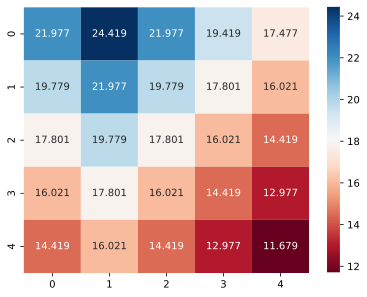

In [19]:
sns.heatmap(grid.values.reshape(5,5), cmap='RdBu', annot=True, fmt=".3f");

## Policy iteration

Initialize $\pi_0$ (random or fixed). For $n=0, 1, 2, \dots$
- Compute the value function $v_{\pi_{n}}$ by solving Bellman expectation linear system
- Compute the value-action function $q_{\pi_{n}}(s, a) = \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_{\pi_{n}}(s')\big)$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}\limits_a q_{\pi_{n}}(s,a)$

**Q.** Rewrite update of $q_\pi$ it terms of MDP-2 framework.

$q_{\pi_{n}}(s, a) = \mathcal R(s,a) + \gamma\sum\limits_{s'} p(s' | s,a)v_{\pi_{n}}(s')$